In [1]:
# https://developers.google.com/earth-engine/tutorials/community/data-converters

In [2]:
# pip install altair
# pip install geopandas

import ee
import geemap
import altair as alt
#import ee
import eerepr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid

In [3]:
ee.Authenticate(auth_mode='notebook')
ee.Initialize()

In [5]:
BASINS_ID = 'WWF/HydroSHEDS/v1/Basins/hybas_6'
BOUNDARIES_ID = 'FAO/GAUL/2015/level1'
CLIMATE_ID = 'WORLDCLIM/V1/MONTHLY'

basins = ee.FeatureCollection(BASINS_ID)
wa = ee.FeatureCollection(BOUNDARIES_ID).filter(
    'ADM0_NAME == "United States of America" && '
    'ADM1_NAME == "Washington"'
)

wa_basins = basins.filterBounds(wa)

In [6]:
precip = ee.ImageCollection(CLIMATE_ID).select('prec')

months = precip.aggregate_array('month').getInfo()

band_names = [f'prec_month_{str(m).zfill(2)}' for m in months]

monthly_precip = ee.Image(precip.toBands().rename(band_names))

monthly_precip.bandNames()

In [7]:
wa_basins = monthly_precip.reduceRegions(
    collection=wa_basins,
    reducer=ee.Reducer.mean(),
    scale=1e3
)

In [8]:
wa_basins.limit(5)

In [9]:
wa_basins_df = ee.data.computeFeatures({
    'expression': wa_basins,
    'fileFormat': 'PANDAS_DATAFRAME'
})

In [10]:
display(type(wa_basins_df))
wa_basins_df.head()

pandas.core.frame.DataFrame

,geo,COAST,DIST_MAIN,DIST_SINK,ENDO,HYBAS_ID,MAIN_BAS,NEXT_DOWN,NEXT_SINK,ORDER,...,prec_month_03,prec_month_04,prec_month_05,prec_month_06,prec_month_07,prec_month_08,prec_month_09,prec_month_10,prec_month_11,prec_month_12
0,"{'type': 'Polygon', 'coordinates': [[[-122.779...",0,110.2,110.2,0,7060394690,7060014930,7060014930,7060014930,1,...,146.878556,94.144313,63.522701,46.212289,17.660385,29.402129,53.578550,105.356210,206.618729,234.763442
1,"{'type': 'Polygon', 'coordinates': [[[-120.916...",0,285.3,285.3,0,7060395190,7060014930,7060394690,7060014930,1,...,27.615579,17.833143,16.877648,13.897495,5.764290,9.287812,12.273582,22.117477,45.264017,50.782735
2,"{'type': 'Polygon', 'coordinates': [[[-120.704...",0,311.1,311.1,0,7060392060,7060014930,7060395190,7060014930,1,...,28.012583,20.677475,18.804275,15.705302,6.606818,10.505247,13.456117,21.139254,47.818868,52.247916
3,"{'type': 'Polygon', 'coordinates': [[[-120.350...",0,369.9,369.9,0,7060390130,7060014930,7060392060,7060014930,1,...,21.068784,17.882572,19.457691,15.483754,5.833698,9.179610,11.897550,18.171781,32.700848,35.842826
4,"{'type': 'Polygon', 'coordinates': [[[-119.358...",0,430.7,430.7,0,7060386330,7060014930,7060390130,7060014930,1,...,27.308765,21.875911,24.330597,17.802391,6.996754,10.967107,13.673581,21.972353,37.138641,38.597492


In [11]:
wa_basins_df = wa_basins_df.melt(
    id_vars=["HYBAS_ID"],
    value_vars=band_names,
    var_name="Month",
    value_name="Precipitation",
)
wa_basins_df

,HYBAS_ID,Month,Precipitation
0,7060394690,prec_month_01,234.094567
1,7060395190,prec_month_01,50.684768
2,7060392060,prec_month_01,48.154425
3,7060390130,prec_month_01,32.510998
4,7060386330,prec_month_01,37.587224
...,...,...,...
523,7060014940,prec_month_12,365.592079
524,7060015100,prec_month_12,339.398352
525,7060015910,prec_month_12,217.663979
526,7060016010,prec_month_12,226.606896


<AxesSubplot:xlabel='HYBAS_ID'>

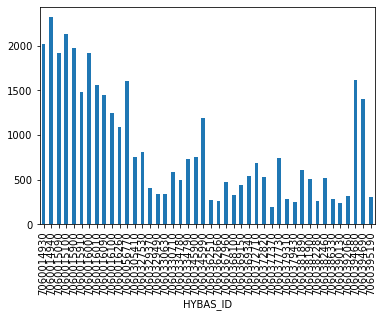

In [12]:
wa_basins_df.groupby(['HYBAS_ID'])['Precipitation'].sum().plot.bar()

In [13]:
alt.Chart(wa_basins_df).mark_bar().encode(
    x=alt.X('HYBAS_ID:O'),
    y=alt.Y('Precipitation:Q', title='Precipitation (mm)'),
    color=alt.Color('Month', scale=alt.Scale(scheme='rainbow')),
    tooltip=alt.Tooltip(['HYBAS_ID', 'Precipitation', 'Month'])
).interactive()

alt.Chart(...)

In [14]:
wa_basins_gdf = ee.data.computeFeatures({
    'expression': wa_basins,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

# Need to set the CRS.
# Make sure it matches the CRS of FeatureCollection geometries.
wa_basins_gdf.crs = 'EPSG:4326'

display(type(wa_basins_gdf))
wa_basins_gdf.head()

geopandas.geodataframe.GeoDataFrame

,geometry,COAST,DIST_MAIN,DIST_SINK,ENDO,HYBAS_ID,MAIN_BAS,NEXT_DOWN,NEXT_SINK,ORDER,...,prec_month_03,prec_month_04,prec_month_05,prec_month_06,prec_month_07,prec_month_08,prec_month_09,prec_month_10,prec_month_11,prec_month_12
0,"POLYGON ((-122.77984 45.62517, -122.77850 45.6...",0,110.2,110.2,0,7060394690,7060014930,7060014930,7060014930,1,...,146.878556,94.144313,63.522701,46.212289,17.660385,29.402129,53.578550,105.356210,206.618729,234.763442
1,"POLYGON ((-120.91667 45.63750, -120.90833 45.6...",0,285.3,285.3,0,7060395190,7060014930,7060394690,7060014930,1,...,27.615579,17.833143,16.877648,13.897495,5.764290,9.287812,12.273582,22.117477,45.264017,50.782735
2,"POLYGON ((-120.70416 45.83750, -120.70381 45.8...",0,311.1,311.1,0,7060392060,7060014930,7060395190,7060014930,1,...,28.012583,20.677475,18.804275,15.705302,6.606818,10.505247,13.456117,21.139254,47.818868,52.247916
3,"POLYGON ((-120.35000 46.03750, -120.34891 46.0...",0,369.9,369.9,0,7060390130,7060014930,7060392060,7060014930,1,...,21.068784,17.882572,19.457691,15.483754,5.833698,9.179610,11.897550,18.171781,32.700848,35.842826
4,"POLYGON ((-119.35833 45.95833, -119.35774 45.9...",0,430.7,430.7,0,7060386330,7060014930,7060390130,7060014930,1,...,27.308765,21.875911,24.330597,17.802391,6.996754,10.967107,13.673581,21.972353,37.138641,38.597492


In [15]:
wa_gdf = ee.data.computeFeatures({
    'expression': wa,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

wa_gdf.crs = 'EPSG:4326'

In [16]:
wa_basins_gdf = wa_basins_gdf.clip(wa_gdf).to_crs(2856)

In [17]:
wa_basins_gdf['prec_total'] = wa_basins_gdf[band_names].sum(axis=1)
wa_basins_gdf.head()

,geometry,COAST,DIST_MAIN,DIST_SINK,ENDO,HYBAS_ID,MAIN_BAS,NEXT_DOWN,NEXT_SINK,ORDER,...,prec_month_04,prec_month_05,prec_month_06,prec_month_07,prec_month_08,prec_month_09,prec_month_10,prec_month_11,prec_month_12,prec_total
11,"POLYGON ((323681.256 38652.563, 323675.358 384...",0,110.3,110.3,0,7060394680,7060014930,7060014930,7060014930,2,...,112.513157,80.506743,54.895933,20.152861,31.470921,59.977676,120.364084,246.904406,268.791477,1612.022388
1,"POLYGON ((467558.207 34606.838, 467927.079 352...",0,285.3,285.3,0,7060395190,7060014930,7060394690,7060014930,1,...,17.833143,16.877648,13.897495,5.764290,9.287812,12.273582,22.117477,45.264017,50.782735,302.936212
0,"POLYGON ((323681.256 38652.563, 324195.862 386...",0,110.2,110.2,0,7060394690,7060014930,7060014930,7060014930,1,...,94.144313,63.522701,46.212289,17.660385,29.402129,53.578550,105.356210,206.618729,234.763442,1397.917320
36,"MULTIPOLYGON (((272907.881 108054.961, 273076....",0,0.0,0.0,0,7060014930,7060014930,0,7060014930,1,...,139.758895,93.194343,72.178947,30.306009,46.373500,83.750910,161.842562,301.742886,322.848658,2014.252252
39,"MULTIPOLYGON (((229004.483 186948.963, 229005....",1,0.0,0.0,0,7060014940,7060014940,0,7060014940,0,...,161.688406,101.882578,74.140903,39.682854,50.261698,96.686944,201.159668,342.369779,365.592079,2321.440637


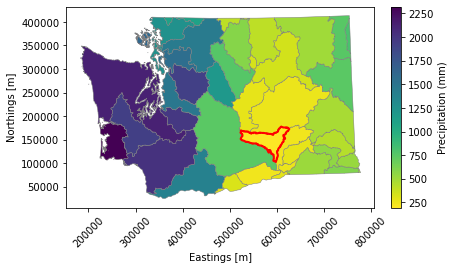

In [18]:
# Define the choropleth map.
ax = wa_basins_gdf.plot(
    column='prec_total',
    cmap='viridis_r',
    vmin=wa_basins_gdf['prec_total'].min(),
    vmax=wa_basins_gdf['prec_total'].max(),
    legend=False,
    edgecolor='grey', linewidth=0.5
)

# Highlight the basin with the minimum annual precipitation: subset the geometry
# with the minimum precipitation total and then add it to the basin
# precipitation plot.
min_prec_gdf = wa_basins_gdf.loc[[wa_basins_gdf['prec_total'].idxmin()]]
min_prec_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=2)

# Add axis labels, a colorbar, and rotate x axis ticks.
ax.set_xlabel('Eastings [m]')
ax.set_ylabel('Northings [m]')
colorbar = plt.colorbar(ax.get_children()[0], fraction=0.03)
colorbar.set_label('Precipitation (mm)')
plt.xticks(rotation=45)

plt.show()

In [19]:
monthly_precip_washington = monthly_precip.clipToBoundsAndScale(
    geometry=wa_basins, scale=1500
)

monthly_precip_npy = ee.data.computePixels({
    'expression': monthly_precip_washington,
    'fileFormat': 'NUMPY_NDARRAY'
})

monthly_precip_npy

array([[( 1.51e+02,  1.07e+02,  9.5e+01,  6.7e+01,  6.1e+01,  5.7e+01,  5.6e+01,  5.1e+01,  6.6e+01,  1.29e+02,  1.51e+02,  1.52e+02),
        ( 1.49e+02,  1.05e+02,  9.2e+01,  6.5e+01,  6.0e+01,  5.5e+01,  5.4e+01,  4.9e+01,  6.6e+01,  1.33e+02,  1.52e+02,  1.50e+02),
        ( 1.49e+02,  1.06e+02,  9.5e+01,  6.7e+01,  6.1e+01,  5.7e+01,  5.6e+01,  5.1e+01,  6.6e+01,  1.26e+02,  1.49e+02,  1.51e+02),
        ...,
        ( 2.60e+01,  2.40e+01,  2.5e+01,  4.0e+01,  5.8e+01,  8.5e+01,  5.9e+01,  5.5e+01,  4.6e+01,  2.30e+01,  2.00e+01,  2.50e+01),
        ( 2.50e+01,  2.40e+01,  2.4e+01,  3.9e+01,  5.7e+01,  8.5e+01,  5.9e+01,  5.5e+01,  4.6e+01,  2.20e+01,  1.90e+01,  2.40e+01),
        ( 2.50e+01,  2.40e+01,  2.4e+01,  3.9e+01,  5.7e+01,  8.5e+01,  5.9e+01,  5.5e+01,  4.6e+01,  2.20e+01,  1.90e+01,  2.40e+01)],
       [( 1.51e+02,  1.06e+02,  9.4e+01,  6.6e+01,  6.0e+01,  5.6e+01,  5.4e+01,  5.0e+01,  6.6e+01,  1.36e+02,  1.55e+02,  1.53e+02),
        ( 1.50e+02,  1.05e+02,  9.2e+01, 

field names: ('prec_month_01', 'prec_month_02', 'prec_month_03', 'prec_month_04', 'prec_month_05', 'prec_month_06', 'prec_month_07', 'prec_month_08', 'prec_month_09', 'prec_month_10', 'prec_month_11', 'prec_month_12')
Selected array (band) shape: (556, 834)


array([[ 1.29e+02,  1.33e+02,  1.26e+02, ...,  2.30e+01,  2.20e+01,
         2.20e+01],
       [ 1.36e+02,  1.39e+02,  1.54e+02, ...,  2.30e+01,  2.30e+01,
         2.20e+01],
       [ 1.48e+02,  1.40e+02,  1.62e+02, ...,  2.30e+01,  2.30e+01,
         2.20e+01],
       ...,
       [-3.40e+38, -3.40e+38, -3.40e+38, ...,  2.00e+01,  1.90e+01,
         1.90e+01],
       [-3.40e+38, -3.40e+38, -3.40e+38, ...,  1.90e+01,  1.90e+01,
         1.90e+01],
       [-3.40e+38, -3.40e+38, -3.40e+38, ...,  2.00e+01,  1.80e+01,
         1.80e+01]], dtype=float32)

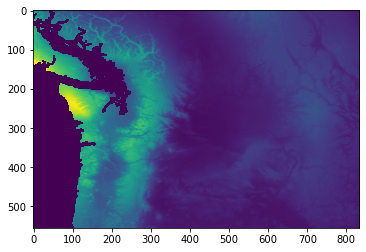

In [20]:
names = monthly_precip_npy.dtype.names
print('field names:', names)

prec_month_10_arr = monthly_precip_npy['prec_month_10']
print('Selected array (band) shape:', prec_month_10_arr.shape)
display(prec_month_10_arr)
plt.imshow(prec_month_10_arr, vmin=0, vmax=320)

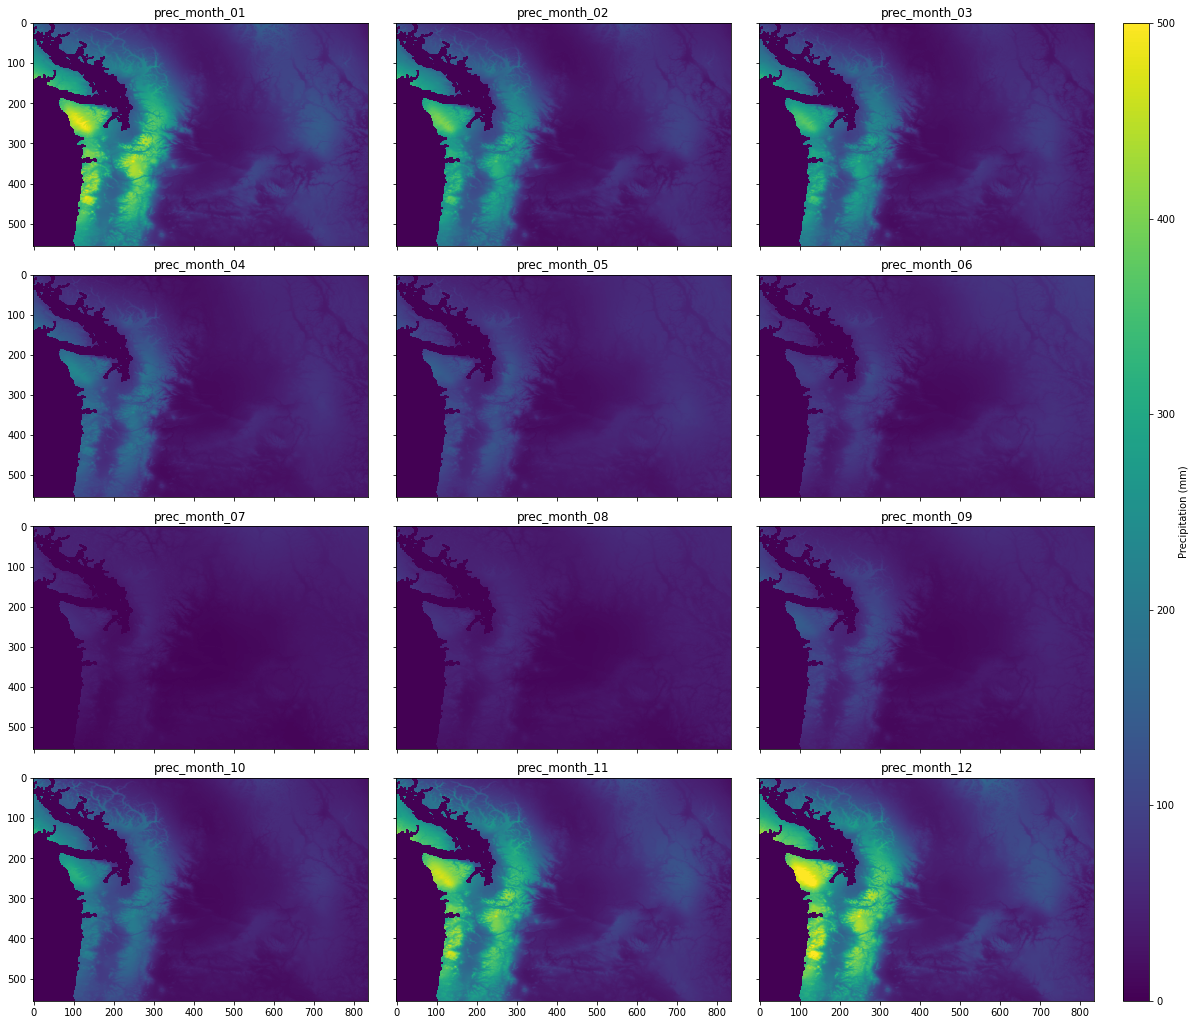

In [21]:
# Set up the figure and grid.
fig = plt.figure(figsize=(20.0, 20.0))
grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(4, 3),
    axes_pad=0.4,
    cbar_mode="single",
    cbar_location="right",
    cbar_pad=0.4,
    cbar_size="2%",
)

# Display each band to a grid cell.
for ax, name in zip(grid, names):
    ax.imshow(monthly_precip_npy[name], vmin=0, vmax=500)
    ax.set_title(name)

# Add colorbar.
colorbar = plt.colorbar(ax.get_children()[0], cax=grid[0].cax)
colorbar.set_label("Precipitation (mm)")

plt.show()

In [22]:
high_order_wa_basins_df = ee.data.listFeatures({
    'assetId': 'WWF/HydroSHEDS/v1/Basins/hybas_6',
    'region': wa.geometry().getInfo(),
    'filter': 'ORDER >= 3',
    'fileFormat': 'PANDAS_DATAFRAME'
})

high_order_wa_basins_df

,geo,COAST,DIST_MAIN,DIST_SINK,ENDO,HYBAS_ID,MAIN_BAS,NEXT_DOWN,NEXT_SINK,ORDER,PFAF_ID,SORT,SUB_AREA,UP_AREA
0,"{'type': 'Polygon', 'coordinates': [[[-121.520...",0,508.7,508.7,0,7060377730,7060014930,7060379430,7060014930,3,782612,277,15930.4,15930.4
1,"{'type': 'Polygon', 'coordinates': [[[-119.966...",0,633.1,633.1,0,7060362660,7060014930,7060377370,7060014930,3,782614,282,11946.4,11946.5
2,"{'type': 'Polygon', 'coordinates': [[[-121.179...",0,727.6,727.6,0,7060345990,7060014930,7060362510,7060014930,3,782616,286,3473.4,3473.4
3,"{'type': 'Polygon', 'coordinates': [[[-120.788...",0,819.8,819.8,0,7060330710,7060014930,7060345900,7060014930,3,782618,292,4680.6,4680.8
4,"{'type': 'Polygon', 'coordinates': [[[-121.099...",0,835.0,835.0,0,7060329370,7060014930,7060330630,7060014930,3,782620,294,21385.8,21385.8
5,"{'type': 'Polygon', 'coordinates': [[[-118.345...",0,1010.9,1010.9,0,7060334790,7060014930,7060329490,7060014930,3,782640,299,17353.6,17353.6
6,"{'type': 'Polygon', 'coordinates': [[[-117.662...",0,1181.3,1181.3,0,7060305410,7060014930,7060334780,7060014930,3,782661,308,4292.1,67055.5
7,"{'type': 'Polygon', 'coordinates': [[[-117.188...",0,1335.1,1335.1,0,7060327530,7060014930,7060305410,7060014930,4,782662,323,2549.2,2549.2


In [23]:
high_order_wa_basins_gdf = ee.data.listFeatures({
    'assetId': 'WWF/HydroSHEDS/v1/Basins/hybas_6',
    'region': wa.geometry().getInfo(),
    'filter': 'ORDER >= 3',
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})

display(type(wa_basins_gdf))
high_order_wa_basins_gdf

geopandas.geodataframe.GeoDataFrame

,geometry,COAST,DIST_MAIN,DIST_SINK,ENDO,HYBAS_ID,MAIN_BAS,NEXT_DOWN,NEXT_SINK,ORDER,PFAF_ID,SORT,SUB_AREA,UP_AREA
0,"POLYGON ((-121.52084 46.87500, -121.51998 46.8...",0,508.7,508.7,0,7060377730,7060014930,7060379430,7060014930,3,782612,277,15930.4,15930.4
1,"POLYGON ((-119.96666 47.18750, -119.96582 47.1...",0,633.1,633.1,0,7060362660,7060014930,7060377370,7060014930,3,782614,282,11946.4,11946.5
2,"POLYGON ((-121.17973 47.90491, -121.17860 47.8...",0,727.6,727.6,0,7060345990,7060014930,7060362510,7060014930,3,782616,286,3473.4,3473.4
3,"POLYGON ((-120.78807 48.62008, -120.78390 48.6...",0,819.8,819.8,0,7060330710,7060014930,7060345900,7060014930,3,782618,292,4680.6,4680.8
4,"POLYGON ((-121.09999 49.40625, -121.09619 49.4...",0,835.0,835.0,0,7060329370,7060014930,7060330630,7060014930,3,782620,294,21385.8,21385.8
5,"POLYGON ((-118.34584 47.89167, -118.34584 47.8...",0,1010.9,1010.9,0,7060334790,7060014930,7060329490,7060014930,3,782640,299,17353.6,17353.6
6,"POLYGON ((-117.66250 48.91250, -117.66004 48.9...",0,1181.3,1181.3,0,7060305410,7060014930,7060334780,7060014930,3,782661,308,4292.1,67055.5
7,"POLYGON ((-117.18807 48.74045, -117.18693 48.7...",0,1335.1,1335.1,0,7060327530,7060014930,7060305410,7060014930,4,782662,323,2549.2,2549.2


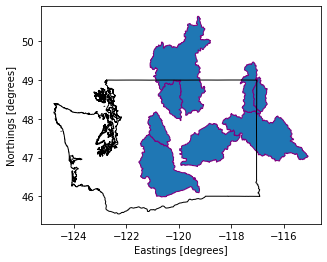

In [24]:
# Create an initial plot with the high river order watersheds.
ax = high_order_wa_basins_gdf.plot(edgecolor='purple', linewidth=1)

# Overlay the Washington state border for context.
wa_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Set axis labels.
ax.set_xlabel('Eastings [degrees]')
ax.set_ylabel('Northings [degrees]')

plt.show()

In [25]:
SCALE_FACTOR = 5

jan_mean_temp_npy = ee.data.getPixels({
    'assetId': 'WORLDCLIM/V1/MONTHLY/01',
    'fileFormat': 'NUMPY_NDARRAY',
    'grid': {
        'dimensions': {
            'width': 360 * SCALE_FACTOR,
            'height': 180 * SCALE_FACTOR
        },
        'affineTransform': {
            'scaleX': 1 / SCALE_FACTOR,
            'shearX': 0,
            'translateX': -180,
            'shearY': 0,
            'scaleY': -1 / SCALE_FACTOR,
            'translateY': 90
        },
        'crsCode': 'EPSG:4326',
    },
    'bandIds': ['tavg']
})

jan_mean_temp_npy

array([[(-3.4e+38,), (-3.4e+38,), (-3.4e+38,), ..., (-3.4e+38,),
        (-3.4e+38,), (-3.4e+38,)],
       [(-3.4e+38,), (-3.4e+38,), (-3.4e+38,), ..., (-3.4e+38,),
        (-3.4e+38,), (-3.4e+38,)],
       [(-3.4e+38,), (-3.4e+38,), (-3.4e+38,), ..., (-3.4e+38,),
        (-3.4e+38,), (-3.4e+38,)],
       ...,
       [(-3.4e+38,), (-3.4e+38,), (-3.4e+38,), ..., (-3.4e+38,),
        (-3.4e+38,), (-3.4e+38,)],
       [(-3.4e+38,), (-3.4e+38,), (-3.4e+38,), ..., (-3.4e+38,),
        (-3.4e+38,), (-3.4e+38,)],
       [(-3.4e+38,), (-3.4e+38,), (-3.4e+38,), ..., (-3.4e+38,),
        (-3.4e+38,), (-3.4e+38,)]], dtype=[('tavg', '<f4')])

In [26]:
jan_mean_temp_npy = jan_mean_temp_npy['tavg']

jan_mean_temp_npy = np.where(jan_mean_temp_npy < -9999, np.nan, jan_mean_temp_npy)
jan_mean_temp_npy = jan_mean_temp_npy * 0.1
jan_mean_temp_npy

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

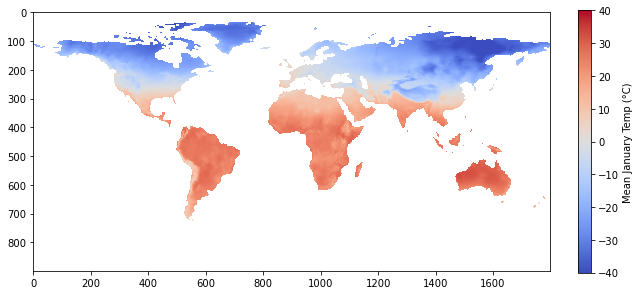

In [27]:
fig = plt.figure(figsize=(10., 10.))
ax = plt.imshow(jan_mean_temp_npy, cmap='coolwarm', vmin=-40, vmax=40)

colorbar = plt.colorbar(ax, fraction=0.0235)
colorbar.set_label('Mean January Temp (°C)')

plt.show()